# Install and Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import folium

from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from pycaret.classification import *

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

import pickle

warnings.filterwarnings('ignore')

# Load data

In [2]:
df = pd.read_csv('../unesco-challenge-corals-distribution/dataset/data.csv')
df.shape

(2471, 10)

# Descriptive Analysis

In [3]:
df.head()

name   salinity  January_temp  June_temp    area  latitude  \
0  Adriatic Sea  38.298527     15.658799  20.855299  138000        43   
1  Adriatic Sea  38.304909     16.297098  19.501200  138000        43   
2  Adriatic Sea  38.462040     16.251598  19.028500  138000        43   
3  Adriatic Sea  38.121601     15.709500  22.882999  138000        43   
4  Adriatic Sea  38.519196     15.733400  21.824799  138000        43   

   longitude  type of sea  corals  silt/sulfide  
0         15            2       1             0  
1         15            2       1             0  
2         15            2       1             0  
3         15            2       1             0  
4         15            2       1             0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2471 non-null   object 
 1   salinity      2471 non-null   float64
 2   January_temp  2471 non-null   float64
 3   June_temp     2471 non-null   float64
 4   area          2471 non-null   int64  
 5   latitude      2471 non-null   int64  
 6   longitude     2471 non-null   int64  
 7   type of sea   2471 non-null   int64  
 8   corals        2471 non-null   int64  
 9   silt/sulfide  2471 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 193.2+ KB


## Numerical features

In [5]:
df.describe().T

count          mean           std           min            25%  \
salinity      2471.0  3.281795e+01  6.620384e+00      5.933204      32.874348   
January_temp  2471.0  1.792853e+01  1.111731e+01     -1.899994       7.890149   
June_temp     2471.0  2.153131e+01  1.014451e+01     -1.899994      19.000000   
area          2471.0  1.006533e+06  1.207700e+06  11500.000000  280000.000000   
latitude      2471.0  1.778066e+01  3.410340e+01    -75.000000      -5.000000   
longitude     2471.0  7.685714e+01  5.499335e+01   -178.000000      28.000000   
type of sea   2471.0  2.681505e+00  5.075721e-01      1.000000       2.000000   
corals        2471.0  8.530959e-01  3.540819e-01      0.000000       1.000000   
silt/sulfide  2471.0  4.937272e-02  2.258376e-01      0.000000       0.000000   

                        50%           75%           max  
salinity          34.191502  3.613582e+01  4.000000e+01  
January_temp      19.497200  2.822470e+01  3.076350e+01  
June_temp         24.600000  2.961455e+01  3.230000e+01  
area          610000.000000  1.150000e+06  5.695000e+06  
latitude          22.000000  4.000000e+01  7.700000e+01  
longitude         65.000000  1.250000e+02  1.630000e+02  
type of sea        3.000000  3.000000e+00  4.000000e+00  
corals             1.000000  1.000000e+00  1.000000e+00  
silt/sulfide       0.000000  0.000000e+00  2.000000e+00

## Categorical features

In [6]:
df.describe(include=object).T

count unique           top freq
name  2471     70  Adriatic Sea   49

## NaN analysis

In [7]:
df.isnull().sum()

name            0
salinity        0
January_temp    0
June_temp       0
area            0
latitude        0
longitude       0
type of sea     0
corals          0
silt/sulfide    0
dtype: int64

## Duplicated values

In [8]:
print('Total of duplicated values:', df[df.duplicated()].shape[0])

Total of duplicated values: 0


# Exploratory Data Analysis

## Number of seas

In [9]:
print('Number of seas in dataset:', df['name'].nunique())

Number of seas in dataset: 70


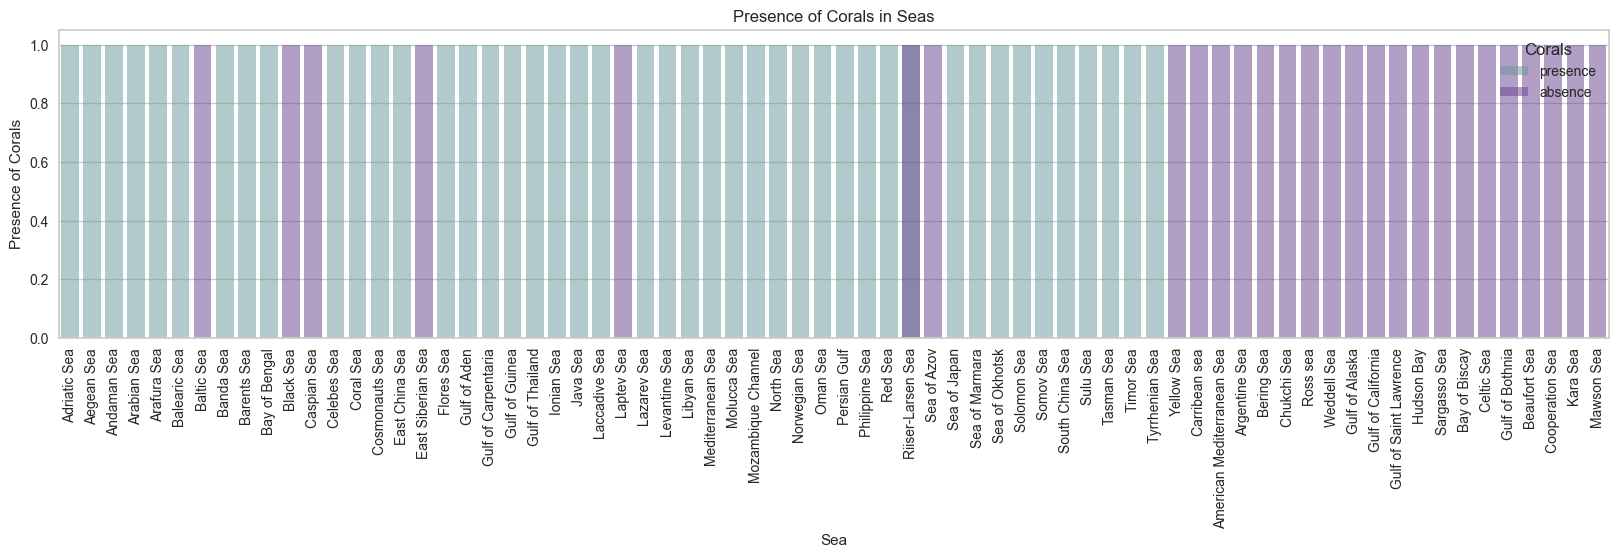

In [10]:
plt.figure(figsize=(20, 4))
sns.barplot(x='name', y=1, data=df.assign(Corals=df['corals'].map({0:'absence',1:'presence'})), hue='Corals', dodge=False, palette=({'presence':'cadetblue','absence':'rebeccapurple'}), alpha=0.5)

plt.xlabel('Sea')
plt.ylabel('Presence of Corals')
plt.title('Presence of Corals in Seas')
plt.xticks(rotation=90)

plt.show()

In [11]:
seas_corals = df.groupby('name')['corals'].nunique()
seas_corals[seas_corals > 1].reset_index()

name  corals
0  Riiser-Larsen Sea       2

The Riiser-Larsen Sea is a marginal sea of the Southern Ocean and the only sea among the 70 in the dataset that has a presence/absence of corals.

In [12]:
df[df['name'].eq('Riiser-Larsen Sea')]

name   salinity  January_temp  June_temp     area  \
1862  Riiser-Larsen Sea  33.884373       -0.4713  -1.899994  1138000   
2470  Riiser-Larsen Sea  33.990000        0.1600  -1.890000  1138000   

      latitude  longitude  type of sea  corals  silt/sulfide  
1862       -68         22            3       1             0  
2470       -68         22            3       0             2

In [13]:
round(df['silt/sulfide'].value_counts(normalize=True)*100,2)

0    95.27
1     4.53
2     0.20
Name: silt/sulfide, dtype: float64

Based on the data above, the only significant difference leading to the absence of corals in this sea is the value 2 for silt/sulfide. A hypothesis that still needs to be validated is whether the presence of silt/sulfide is equivalent to the absence of corals.

The data dictionary indicates that:

- 0 indicates absence of silt/sulfide
- 1 indicates presence of silt/sulfide

 I am assuming that value "2" means no clear information. Since this represents 0.20% of the total, these values will be dropped.

In [14]:
df[df['silt/sulfide'].eq(2)]

name  salinity  January_temp  June_temp     area  latitude  \
2466       Beaufort Sea     30.00         -1.80      -1.40   476000        72   
2467    Cooperation Sea     33.62          0.12      -1.89   258000       -65   
2468           Kara Sea     27.76         -1.89       6.90   926000        77   
2469         Mawson Sea     33.98         -1.50      -1.89   333000       -65   
2470  Riiser-Larsen Sea     33.99          0.16      -1.89  1138000       -68   

      longitude  type of sea  corals  silt/sulfide  
2466       -137            3       0             2  
2467         72            3       0             2  
2468         77            3       0             2  
2469        105            3       0             2  
2470         22            3       0             2

In [15]:
print('Dataframe shape before drop value "2" of silt/sulfide:', df.shape[0])

df = df[~df['silt/sulfide'].eq(2)]

print('Dataframe shape after drop value "2" of silt/sulfide:', df.shape[0])

Dataframe shape before drop value "2" of silt/sulfide: 2471
Dataframe shape after drop value "2" of silt/sulfide: 2466


## Type of seas

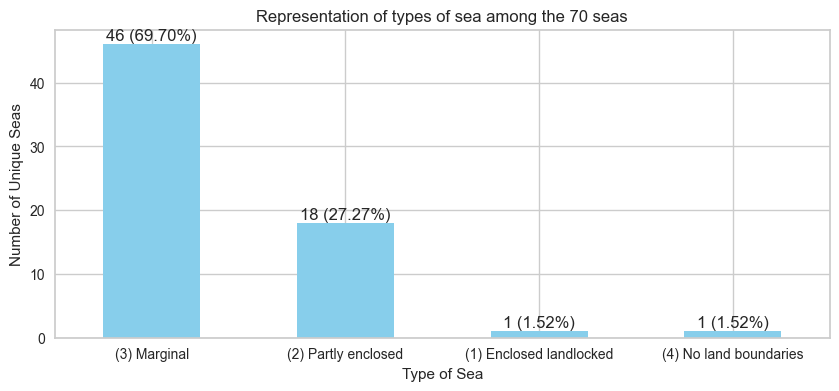

In [16]:
unique_seas = df.groupby('type of sea')['name'].nunique().sort_values(ascending=False)

percentages = (unique_seas / unique_seas.sum()) * 100

plt.figure(figsize=(10, 4))
unique_seas.plot(kind='bar', color='skyblue')
plt.xlabel('Type of Sea')
plt.ylabel('Number of Unique Seas')
plt.title(f'Representation of types of sea among the 70 seas')
plt.xticks(rotation=0)

ax = plt.gca()
type_mapping = {
    1: '(1) Enclosed landlocked',
    2: '(2) Partly enclosed',
    3: '(3) Marginal',
    4: '(4) No land boundaries'
}

ax.set_xticklabels([type_mapping.get(i, str(i)) for i in unique_seas.index])

for i, (v, p) in enumerate(zip(unique_seas, percentages)):
    plt.text(i, v + 0.1, f'{v} ({p:.2f}%)', ha='center', va='bottom')

plt.show()

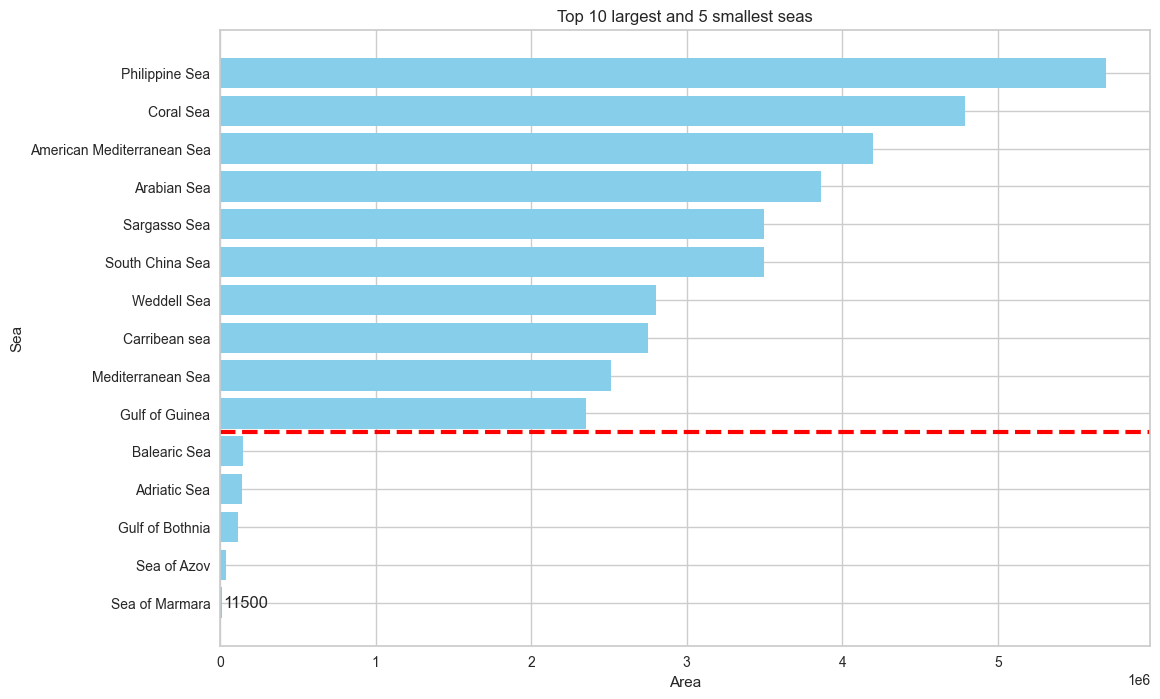

In [17]:
df_sea_areas = df.groupby('name', as_index=False).max().sort_values(by='area',ascending=False)

df_top_10_largest_sea = df_sea_areas.head(10)
df_top_10_smallest_sea = df_sea_areas.tail(5)

df_graph_sea_area = pd.concat([df_top_10_largest_sea, df_top_10_smallest_sea])

df_graph_sea_area = df_graph_sea_area.sort_values(by='area', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(df_graph_sea_area['name'], df_graph_sea_area['area'], color='skyblue')
plt.xlabel('Area')
plt.ylabel('Sea')
plt.title('Top 10 largest and 5 smallest seas')

sep_index = len(df_top_10_smallest_sea)
plt.axhline(y=sep_index - 0.5, color='red', linestyle='--', linewidth= 3)

min_area_value = df_graph_sea_area['area'].iloc[0]
min_area_name = df_graph_sea_area['name'].iloc[0]
plt.text(min_area_value + 5000, 0, f'{min_area_value}', va='center')

plt.show()

In [18]:
print(f"{df_graph_sea_area['name'].iloc[-1]} occupies the first position as the biggest sea with an area of {max(df_graph_sea_area['area'])} square kilometers and the smallest one is {df_graph_sea_area['name'].iloc[0]} ({min(df_graph_sea_area['area'])} square kilometers).")

Philippine Sea occupies the first position as the biggest sea with an area of 5695000 square kilometers and the smallest one is Sea of Marmara (11500 square kilometers).


## Temperature

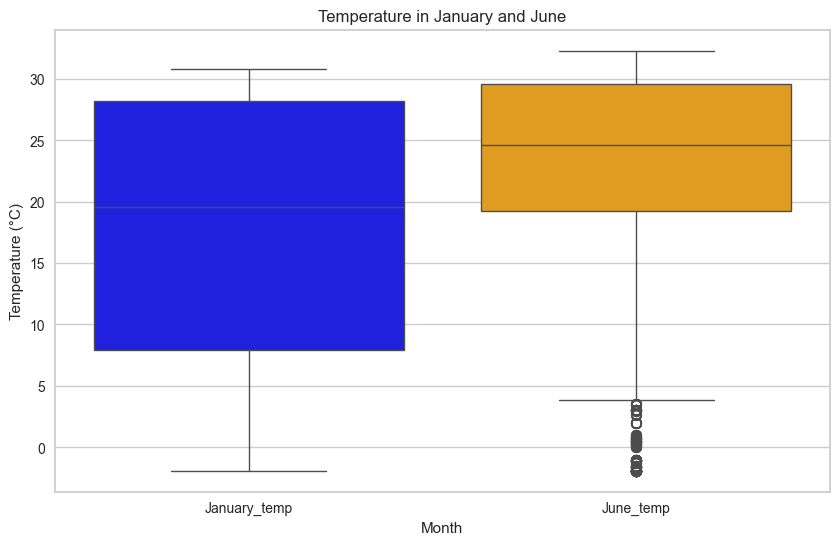

In [19]:
df_melted = df.melt(value_vars=['January_temp', 'June_temp'], var_name='Month', value_name='Temperature')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Temperature', data=df_melted, palette=['blue', 'orange'])
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in January and June')

plt.show()

This is a particular case where removing the June outliers is not applicable, as various regions of the world are being considered, and temperatures can vary to extremes values.

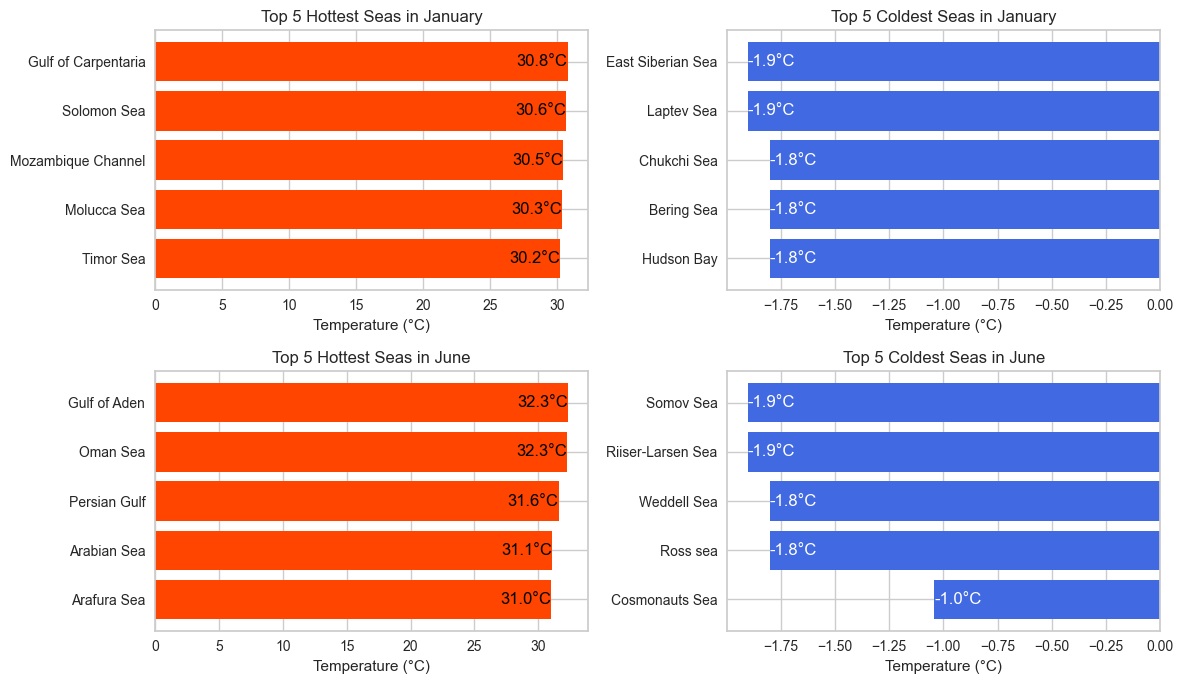

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

hottest_jan = df.groupby('name', as_index=False).max().sort_values(by='January_temp', ascending=False).head(5)
coldest_jan = df.groupby('name', as_index=False).max().sort_values(by='January_temp', ascending=False).tail(5)
hottest_june = df.groupby('name', as_index=False).max().sort_values(by='June_temp', ascending=False).head(5)
coldest_june = df.groupby('name', as_index=False).max().sort_values(by='June_temp', ascending=False).tail(5)

axs[0, 0].barh(hottest_jan['name'], hottest_jan['January_temp'], color='orangered')
axs[0, 0].set_title('Top 5 Hottest Seas in January')
axs[0, 0].set_xlabel('Temperature (°C)')
axs[0, 0].invert_yaxis()
for i, v in enumerate(hottest_jan['January_temp']):
    axs[0, 0].text(v, i, str(round(v,1))+'°C', color='black', va='center', horizontalalignment='right')

axs[0, 1].barh(coldest_jan['name'], coldest_jan['January_temp'], color='royalblue')
axs[0, 1].set_title('Top 5 Coldest Seas in January')
axs[0, 1].set_xlabel('Temperature (°C)')
for i, v in enumerate(coldest_jan['January_temp']):
    axs[0, 1].text(v, i, str(round(v,1))+'°C', color='white', va='center', horizontalalignment='left')

axs[1, 0].barh(hottest_june['name'], hottest_june['June_temp'], color='orangered')
axs[1, 0].set_title('Top 5 Hottest Seas in June')
axs[1, 0].set_xlabel('Temperature (°C)')
axs[1, 0].invert_yaxis()
for i, v in enumerate(hottest_june['June_temp']):
    axs[1, 0].text(v, i, str(round(v,1))+'°C', color='black', va='center', horizontalalignment='right')

axs[1, 1].barh(coldest_june['name'], coldest_june['June_temp'], color='royalblue')
axs[1, 1].set_title('Top 5 Coldest Seas in June')
axs[1, 1].set_xlabel('Temperature (°C)')
for i, v in enumerate(coldest_june['June_temp']):
    axs[1, 1].text(v, i, str(round(v,1))+'°C', color='white', va='center', horizontalalignment='left')

plt.tight_layout()
plt.show()

## Representation of target "corals" for each variable

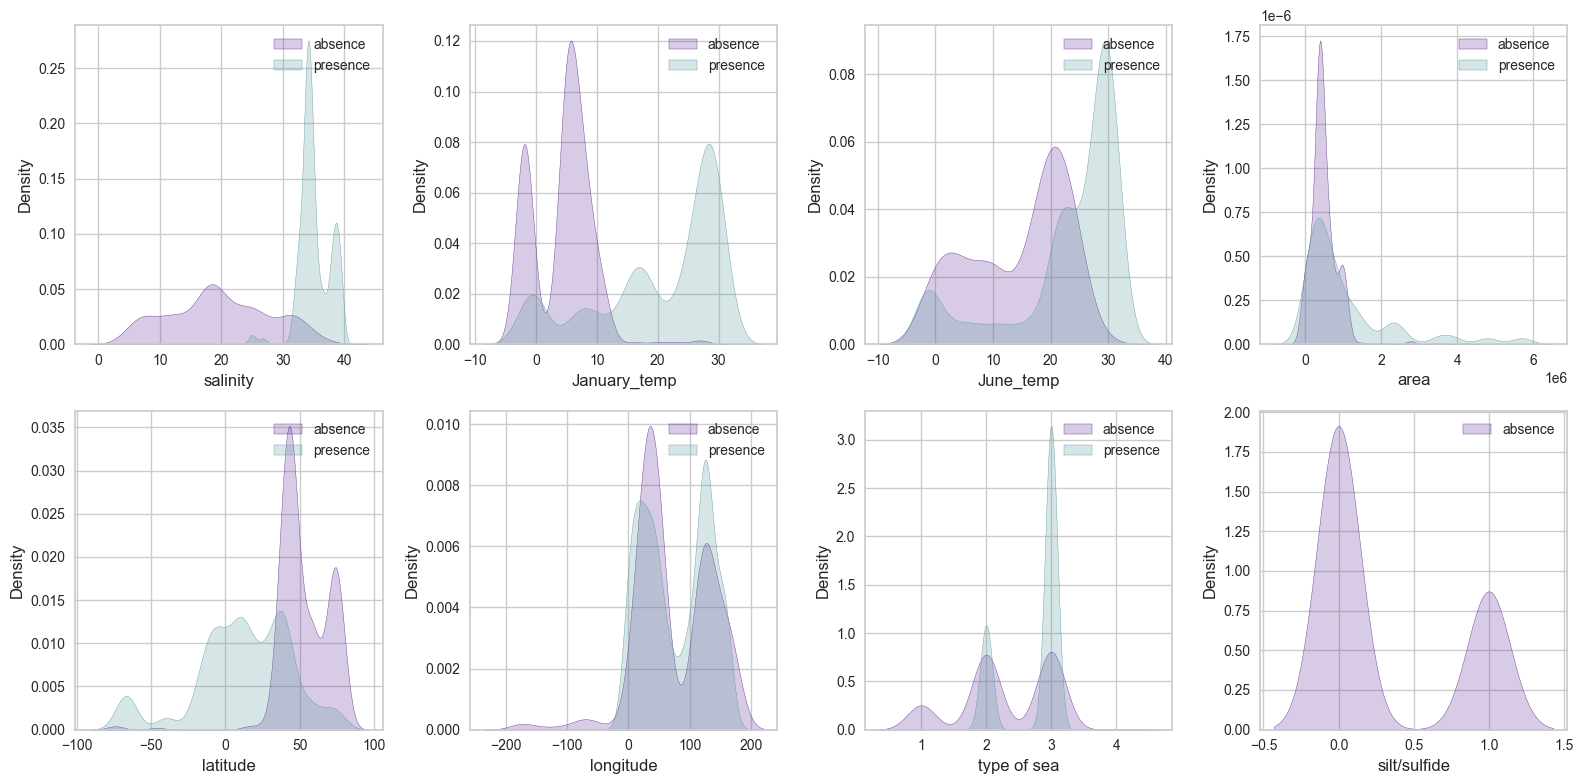

In [21]:
corals_0 = df[df['corals'] == 0]
corals_1 = df[df['corals'] == 1]

columns = ['salinity','January_temp','June_temp', 
            'area','latitude','longitude', 
            'type of sea','silt/sulfide']

num_plots = len(columns)
num_rows = num_plots // 4 + (num_plots % 4 > 0)
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, num_rows*4))

for i, column in enumerate(columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax = sns.kdeplot(
        corals_0[column], 
        color='rebeccapurple', 
        label='absence', 
        fill=True, 
        ax=ax, 
        warn_singular=False
    )
    
    ax = sns.kdeplot(
        corals_1[column], 
        color='cadetblue', 
        label='presence', 
        fill=True, 
        ax=ax, 
        warn_singular=False
    )
    
    ax.legend()
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Density', fontsize=12)

if num_plots < num_rows * 4:
    for i in range(num_plots, num_rows * 4):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()

- Salinity emerges as the most crucial factor in differentiating areas suitable for coral habitation from those where corals cannot thrive. This observation is supported not only by our dataset but also by scientific research, which highlights salinity as a critical factor for coral survival, particularly during times of global warming;

- The presence of silt or sulfide on the sea bottom or in the water makes coral existence impossible. This phenomenon is evident, for example, in the case of the Yellow Sea, where water is heavily laden with silt from rivers. Therefore, silt or sulfide content is a significant feature that characterizes only 'non-coral' areas;

- Enclosed landlocked seas mentioned in this dataset are not the dwellings for corals;

- Surprizingly, both January temperature and latitude (!) can play a role in distinguishing between 'coral' and 'non-coral' seas.

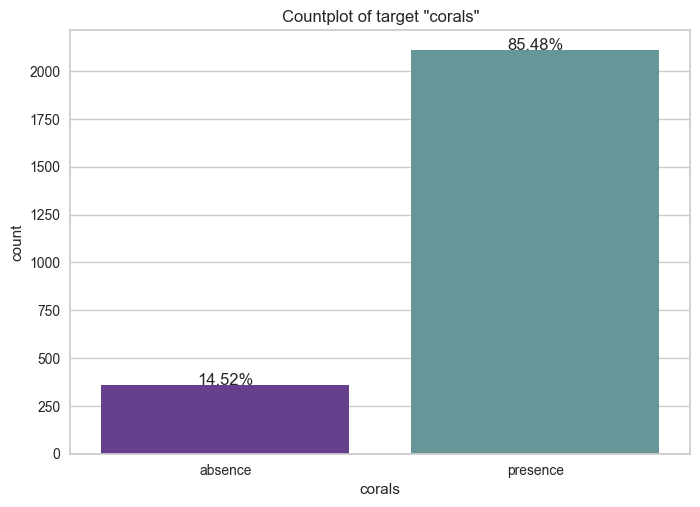

In [22]:
ax = sns.countplot(x='corals', data=df, palette=({'1':'cadetblue','0':'rebeccapurple'}))

total = len(df['corals'])

presence_mapping = {
    0: 'absence',
    1: 'presence'
}

ax.set_xticklabels([presence_mapping.get(i, str(i)) for i in df.index])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:.2f}%'.format((height / total) * 100), ha="center")

plt.title('Countplot of target "corals"')
plt.show()

Due to the target's imbalance, I will balance it later using the SMOTE method. When distinguishing the most important features by type ('coral' or 'non-coral'), it becomes evident that:

- 'non-coral' areas are characterized by narrow range of January temperatures and low salinity in majority of cases;
- in contrast, areas inhabited by corals show wide range of January temperatures and salinity not less than 24-25 PSU.

In [23]:
f = folium.Figure(width=1200, height=600)

m = folium.Map(location=[41, 12], tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}',
               attr = 'Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri',
               zoom_start=2).add_to(f)

# Choose the colors for the markers
def color_maker(status):
    if status == 0:
        return 'purple'
    elif status == 1:
        return 'green'
    else:
        return 'black'
    
# Add markers with colors
for _, row in df.iterrows():
    status = row['corals']
    color = color_maker(status)
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(
        '{}, salinity: {:.2f} PSU, silt/sulfide: {}, area: {} sq km, '
        'January temperature: {:.2f}°C, June temperature: {:.2f}°C'
        .format(
            row['name'],
            row['salinity'],
            row['silt/sulfide'],
            row['area'],
            row['January_temp'],
            row['June_temp']
            )
        ),
        icon=folium.Icon(icon = 'sun', prefix='fa', color=color)
    ).add_to(m)
    
# Legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 160px; height: 100px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 opacity: 0.8;
                 ">
        
        <p><b><i class="fa fa-map-marker fa-1x" style="color: purple"></i> - Absence of corals<b></p>
        <p><i class="fa fa-map-marker fa-1x" style="color: green"></i> - Presence of corals</p>
        <p><i class="fa fa-map-marker fa-1x" style="color: black"></i> - No clear info</p>
    </div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

m

To iteract with the dynamic map, please check this notebook at https://nbviewer.org/github/guilhermegarcia-ai/ml-classification-models/blob/main/unesco-challenge-corals-distribution/unesco_corals_distribution_classification.ipynb.

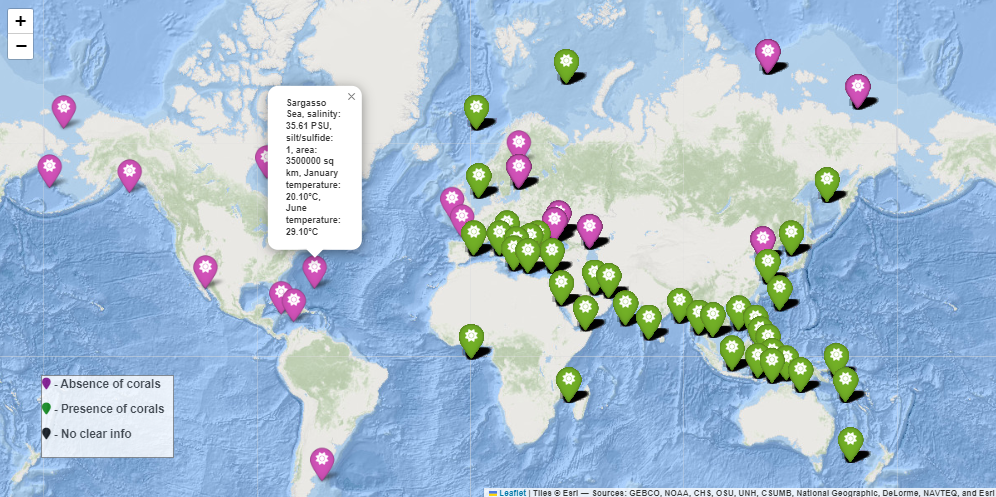

## Correlation

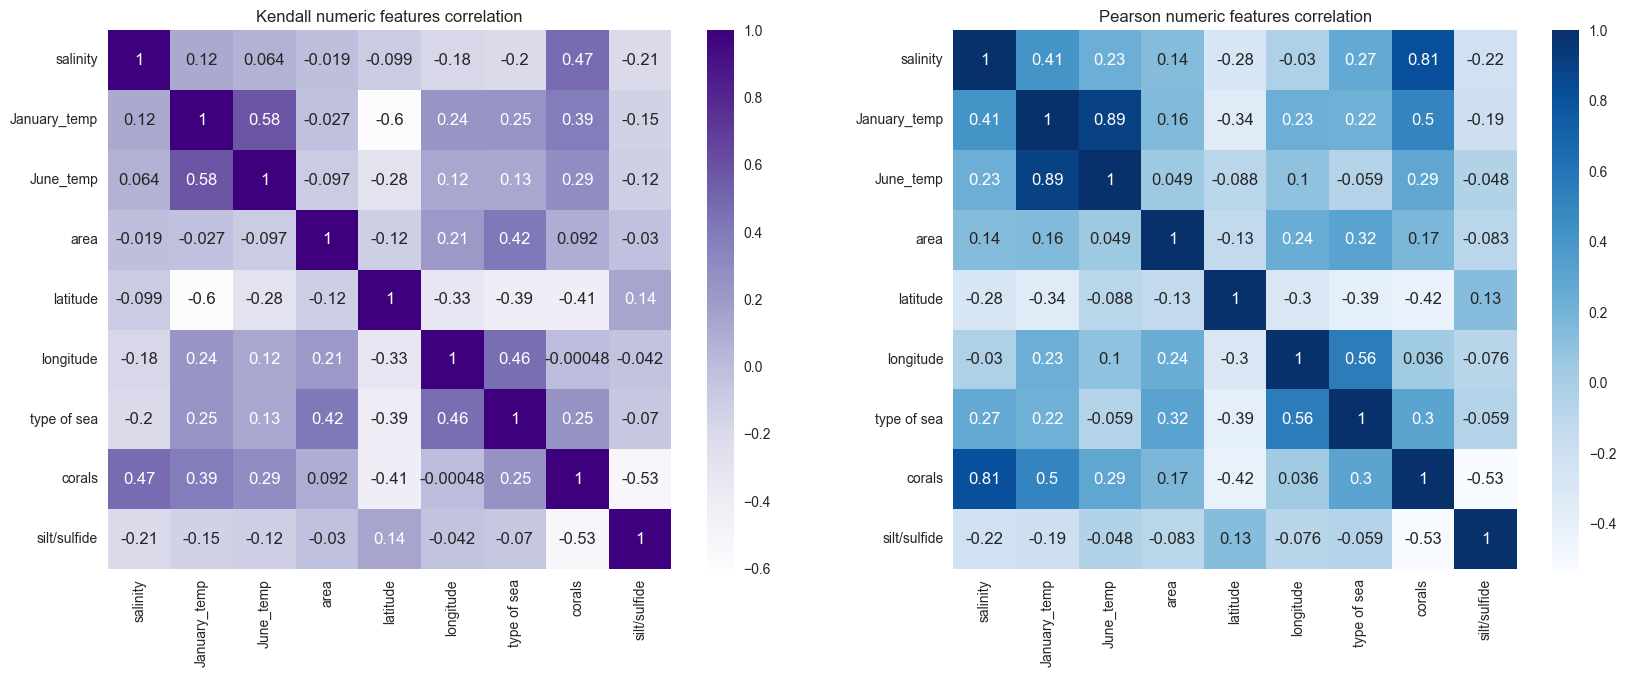

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

sns.heatmap(df.corr(method='kendall'), annot=True, cmap='Purples', ax=axs[0])
axs[0].set_title('Kendall numeric features correlation')

sns.heatmap(df.corr(), annot=True, cmap='Blues', ax=axs[1])
axs[1].set_title('Pearson numeric features correlation')

plt.show()

Considering the Kendall matrix, it is possible to see that the target value is correlated with salinity of seas (0.47), temperatures in January (0.39), latitude (-0.41) and specification of bottom silt/sulfide (-0.53).

# Predictive Model

## Train test split

In [25]:
df_train_test = df.sample(frac= 0.95, random_state=42)
df_validate = df.drop(df_train_test.index)

df_train_test.reset_index(drop=True, inplace= True)
df_validate.reset_index(drop=True, inplace= True)

print('95% of data for modeling:', df_train_test.shape)
print('05% of data for validate:', df_validate.shape)

95% of data for modeling: (2343, 10)
05% of data for validate: (123, 10)


In [26]:
X = df_train_test.drop(columns=['name','corals'])
y = df_train_test['corals']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1874, 8)
(1874,)
(469, 8)
(469,)


## Pipeline (Class balancing, Scaling, Cross-validating and Tune)

In [28]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('SVC', SVC(probability=True)),
    ('Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('LGBM', LGBMClassifier(verbose=-1)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# Define cross-validation metrics
cross_val_metrics = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

# List to store results
results = []

# Dictionary to store best estimators
best_estimators = {}

# Define StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over the models
for name, model in models:
    # Define the pipeline
    pipeline = imbpipeline(steps=[
        ['nearmiss', NearMiss()],
        ['scaler', StandardScaler()],
        ['classifier', model]
    ])
    
    # Define the parameter grid specific to each model
    if name == 'Logistic Regression':
        param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                      'classifier__max_iter': [100, 300, 500, 1000],
                      'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                      'classifier__solver': ['lbfgs','newton-cg','liblinear','sag','saga']}
    elif name == 'SVC':
        param_grid = {'classifier__C': [0.01, 0.1, 1, 10, 100], 
                      'classifier__kernel': ['linear', 'rbf']}
    elif name == 'K-Nearest Neighbors':
        param_grid = {'classifier__n_neighbors': [3, 5, 7, 9]}
    elif name == 'Decision Tree':
        param_grid = {'classifier__max_depth': [None, 5, 10]}
    elif name == 'Random Forest':
        param_grid = {'classifier__n_estimators': [50, 100, 200], 
                      'classifier__max_depth': [None, 5, 10]}
    elif name == 'Gradient Boosting':
        param_grid = {'classifier__n_estimators': [50, 100, 200], 
                      'classifier__learning_rate': [0.01, 0.1, 0.2], 
                      'classifier__max_depth': [3, 5, 7]}
    elif name == 'LGBM':
        param_grid = {'classifier__n_estimators': [50, 100, 200], 
                      'classifier__learning_rate': [0.01, 0.1, 0.2], 
                      'classifier__max_depth': [3, 5, 7]}
    elif name == 'XGBoost':
        param_grid = {'classifier__n_estimators': [50, 100, 200], 
                      'classifier__learning_rate': [0.01, 0.1, 0.2], 
                      'classifier__max_depth': [3, 5, 7]}
    else:
        param_grid = {}

    # Create the GridSearchCV with refit on 'roc_auc'
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring=cross_val_metrics,
                               refit='roc_auc',
                               cv=stratified_kfold,
                               n_jobs=-1)

    # Fit the GridSearchCV on the training data
    grid_search.fit(X_train, y_train)

    # Save the best estimator for the current model
    best_estimators[name] = grid_search.best_estimator_['classifier']

    # Evaluate the best model on the test set for all metrics
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

    test_scores = {
        'accuracy': round(accuracy_score(y_test, y_pred), 3),
        'precision': round(precision_score(y_test, y_pred), 3),
        'recall': round(recall_score(y_test, y_pred), 3),
        'f1': round(f1_score(y_test, y_pred), 3),
        'roc_auc': round(roc_auc_score(y_test, y_pred_proba), 3)
    }

    # Add results to the DataFrame
    results.append({
        'model': name,
        **test_scores
    })

## Evaluation

In [29]:
df_model_comparison = pd.DataFrame(results)

df_model_comparison.sort_values(by='roc_auc',ascending=False)

model  accuracy  precision  recall     f1  roc_auc
1                  SVC     0.667      1.000   0.611  0.759    0.999
5        Random Forest     0.821      1.000   0.791  0.883    0.999
0  Logistic Regression     0.776      1.000   0.738  0.849    0.966
7                 LGBM     0.900      1.000   0.883  0.938    0.951
8              XGBoost     0.823      1.000   0.793  0.885    0.937
3  K-Nearest Neighbors     0.836      0.997   0.810  0.894    0.936
6    Gradient Boosting     0.806      1.000   0.773  0.872    0.903
4        Decision Tree     0.823      1.000   0.793  0.885    0.897
2          Naive Bayes     0.733      1.000   0.688  0.815    0.848

In [30]:
best_model = best_estimators['Random Forest']
print(best_model)

RandomForestClassifier(max_depth=5, n_estimators=200)


In [31]:
final_pipeline = imbpipeline(steps=[
                            ['nearmiss', NearMiss()],
                            ['scaler', StandardScaler()],
                            ['classifier', best_model]
                    ])

final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      1.00      0.62        68
           1       1.00      0.79      0.88       401

    accuracy                           0.82       469
   macro avg       0.72      0.90      0.75       469
weighted avg       0.92      0.82      0.84       469



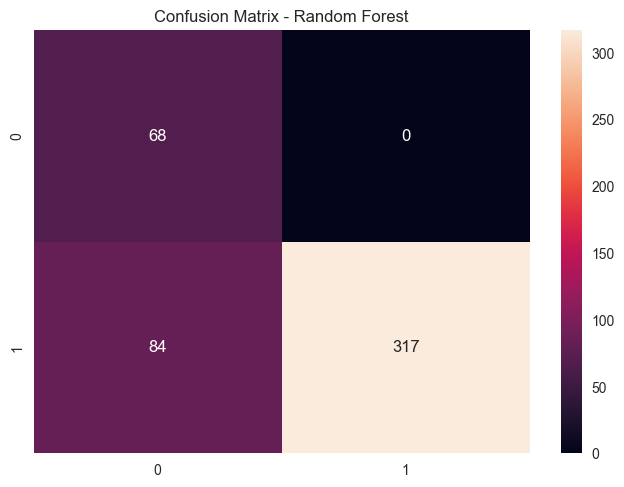

In [33]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.title('Confusion Matrix - Random Forest');

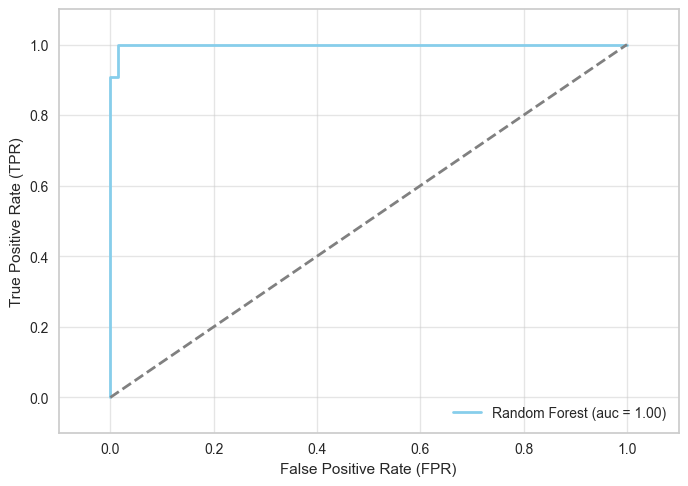

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='skyblue', lw=2, label=f'Random Forest (auc = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

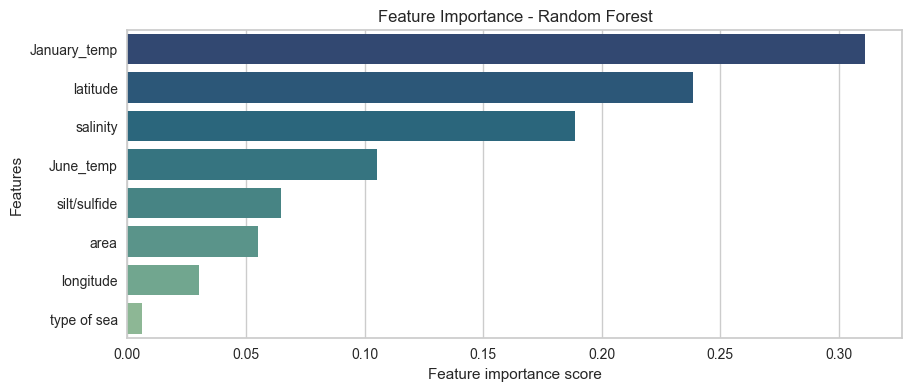

In [35]:
feature_scores = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 4))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, palette='crest_r')
ax.set_title("Feature Importance - Random Forest")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

## Save model

In [36]:
pickle.dump(best_model, open('./deploy-streamlit/models/model_rf.pkl', 'wb'))

In [37]:
df_validate.drop(columns='corals').to_csv('deploy-streamlit/validation-dataset/Xtest.csv', index = False)